# 3. (Optional) Concordance

In [128]:
## Import libraries 
import os
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [ ]:
## Set working directory
os.chdir("/Path/To/Your/Working Directory/") 
dir = 'Output/3-Concordance/'
os.makedirs(dir, exist_ok = True)

In [130]:
## Configuration
Label = ["CD-P", "CD-PN", "CD-NF", "CD-FA", "CD-A"]
Mapping1 = {0: "CD-P", 1: "CD-PN", 2: "CD-NF", 3: "CD-FA", 4: "CD-A"}
Mapping2 = {"CD-P": 0, "CD-PN": 1, "CD-NF": 2, "CD-FA": 3, "CD-A": 4}
cmap = {"CD-P": "#fdcc83", "CD-PN": "#f6afb0", "CD-NF": "#c27cd6", "CD-FA": "#71b3a8", "CD-A": "#6292b0"}

## 1. Prepare Data

In [ ]:
## Get NMF-derived and predicted subtypes
Subtype_NMF = pd.read_csv('Data/CPTAC/PCD_Subtype_NMF.tsv', delimiter = '\t')
Subtype_NMF = Subtype_NMF.set_index("ID_sample")
Prediction = pd.read_csv('Output/1-Infer_PCD_subtype/Prediction.tsv', delimiter = '\t')
Prediction = Prediction.set_index("ID_sample")

Subtype = pd.merge(Subtype_NMF[["PCD_subtype"]], Prediction, left_index = True, right_index = True, how = "left")
Subtype.rename(columns={'Subtype': 'PCD_Subtype_predicted'}, inplace = True)
Subtype.rename(columns={'PCD_subtype': 'PCD_Subtype_NMF'}, inplace = True)
Subtype

,PCD_Subtype_NMF,PCD_Subtype_predicted,Probability_CD-P,Probability_CD-PN,Probability_CD-NF,Probability_CD-FA,Probability_CD-A,Max_Probability
ID_sample,,,,,,,,
00848ea4-c3f9-40bb-b37d-c084eaf51dcb,CD-PN,CD-PN,2.801286e-04,0.902799,0.088902,0.000198,7.821185e-03,0.902799
00ff9dcc-d053-42d1-8c0c-1b67f9c080da__9b446072-9587-4282-b448-ece42ad1989b,CD-PN,CD-NF,6.354944e-07,0.000011,0.999984,0.000003,6.454953e-07,0.999984
0291f03c-1348-40e1-b4f0-1d9c9683de41__1144ee40-6830-4df2-b072-7ff9f2dd9550__7ed3d7a2-dd9c-4557-ba6b-8fcc2a7f02a2__ac8664aa-6fe4-429a-8223-ea6920f9fe0f,CD-PN,CD-PN,3.528766e-06,0.988468,0.006781,0.000049,4.699185e-03,0.988468
046bf2fc-bbc1-4b09-a91c-af7c1813a186,CD-P,CD-P,9.986700e-01,0.000008,0.000120,0.000066,1.136358e-03,0.998670
047df64a-d51f-44dd-a921-c4761ae9596f,CD-P,CD-P,9.969345e-01,0.000008,0.000001,0.000006,3.051466e-03,0.996935
...,...,...,...,...,...,...,...,...
CPT0238110007,CD-P,CD-A,9.488311e-03,0.007018,0.000744,0.025974,9.567756e-01,0.956776
CPT0241170009,CD-PN,CD-PN,2.464862e-06,0.996815,0.001253,0.000011,1.919120e-03,0.996815
CPT0245780009,CD-A,CD-A,1.455745e-03,0.002141,0.000004,0.000026,9.963732e-01,0.996373


In [132]:
PCD_Subtype_NMF = Subtype["PCD_Subtype_NMF"].copy().map(Mapping2)
PCD_Subtype_predicted = Subtype["PCD_Subtype_predicted"].copy().map(Mapping2)
Probability = Subtype[[c for c in Prediction.columns if c.startswith("Probability_")]].values

## 2. Performance

In [ ]:
## Performance
Performance = {}
PCD_Subtype_NMF_class = label_binarize(PCD_Subtype_NMF, classes=[0, 1, 2, 3, 4])

# AUC
Performance["AUC_macro"] = metrics.roc_auc_score(PCD_Subtype_NMF_class, Probability, multi_class = 'ovr', average = 'macro')
for i in range(5):
    fpr, tpr, _ = metrics.roc_curve(
        PCD_Subtype_NMF_class[:, i], Probability[:, i], pos_label = 1
    )
    Performance[f"AUC_{i+1}"] = metrics.auc(fpr, tpr)
    Performance[f"PR_{i+1}"] = metrics.average_precision_score(
        PCD_Subtype_NMF_class[:, i], Probability[:, i], average = 'macro'
    )

# Classification Report
ClassRep = metrics.classification_report(PCD_Subtype_NMF, PCD_Subtype_predicted, output_dict = True)
Performance["Accuracy"] = ClassRep["accuracy"]
Performance["Precision_macro"] = ClassRep["macro avg"]["precision"]
Performance["Recall_macro"] = ClassRep["macro avg"]["recall"]
Performance["F1-score_macro"] = ClassRep["macro avg"]["f1-score"]
for i in range(5):
    Performance[f"Precision_{i+1}"] = ClassRep[str(i)]["precision"]
    Performance[f"Recall_{i+1}"] = ClassRep[str(i)]["recall"]
    Performance[f"F1-score_{i+1}"] = ClassRep[str(i)]["f1-score"]

# Format output
Performance_overall = pd.DataFrame({
    "Accuracy": [Performance["Accuracy"]],
    "AUC_macro": [Performance["AUC_macro"]],
    "Precision_macro": [Performance["Precision_macro"]],
    "Recall_macro": [Performance["Recall_macro"]],
    "F1-score_macro": [Performance["F1-score_macro"]]
})
Performance_subtype = pd.DataFrame({
    "Subtype": Label,
    "AUC": [Performance[f"AUC_{i+1}"] for i in range(5)],
    "PR": [Performance[f"PR_{i+1}"] for i in range(5)],
    "Precision": [Performance[f"Precision_{i+1}"] for i in range(5)],
    "Recall": [Performance[f"Recall_{i+1}"] for i in range(5)],
    "F1-score": [Performance[f"F1-score_{i+1}"] for i in range(5)]
})
Performance_overall.to_csv(dir + "Performance_overall.tsv", sep="\t", index=False)
Performance_subtype.to_csv(dir + "Performance_subtype.tsv", sep="\t", index=False)
print(Performance_overall)
print(Performance_subtype)

   Accuracy  AUC_macro  Precision_macro  Recall_macro  F1-score_macro
0  0.517483   0.819572          0.51928      0.522986         0.50582
  Subtype       AUC        PR  Precision    Recall  F1-score
0    CD-P  0.855515  0.554356   0.574468  0.487952  0.527687
1   CD-PN  0.698066  0.437193   0.456140  0.280576  0.347439
2   CD-NF  0.748181  0.286886   0.287037  0.492063  0.362573
3   CD-FA  0.879392  0.669277   0.673077  0.530303  0.593220
4    CD-A  0.916706  0.777011   0.605678  0.824034  0.698182


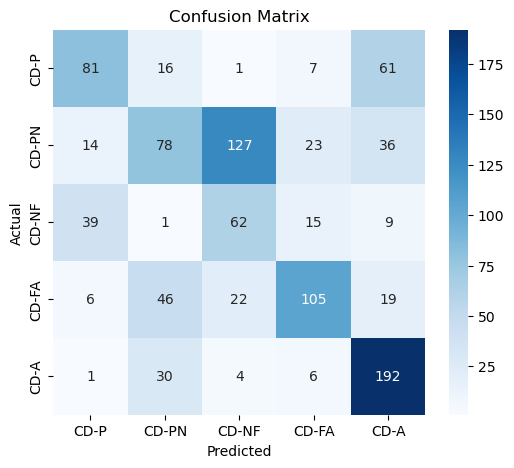

In [134]:
## Confusion matrix
cm = metrics.confusion_matrix(PCD_Subtype_NMF, PCD_Subtype_predicted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = Label, yticklabels = Label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig(dir + 'Confusion_matrix.png', dpi = 300)

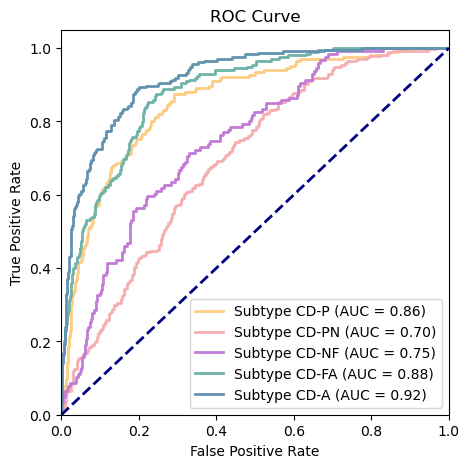

In [ ]:
## ROC Curve
plt.figure(figsize = (5, 5))
lw = 2
for i in range(5):
    fpr, tpr, thresholds = metrics.roc_curve(PCD_Subtype_NMF_class[:, i], Probability[:, i], pos_label = 1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = lw, color = cmap[Mapping1[i]], label = 'Subtype {0} (AUC = {1:0.2f})'.format(Mapping1[i], roc_auc))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.savefig(dir + 'ROC.png', dpi = 300)